In [ ]:
import pandas as pd
import glob
import os
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Call for merged data

In [ ]:
calming_df = pd.read_csv('Calming_Merged_feature.csv')
vexing_df = pd.read_csv('Vexing_Merged_feature.csv')
music_df = pd.read_csv('Music_Merged_features.csv')

In [ ]:
# Drop the 'Unnamed: 0' column if it exists in calming_df and vexing_df
if 'Unnamed: 0' in calming_df.columns:
    calming_df = calming_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in vexing_df.columns:
    vexing_df = vexing_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0.1' in music_df.columns:
    music_df = music_df.drop(columns=['Unnamed: 0.1'])
if 'Unnamed: 0' in music_df.columns:
    music_df = music_df.drop(columns=['Unnamed: 0'])

In [ ]:
calming_df.head()

,n_back,Response_Time,condition,subject_id,BlockNumber,TrialInBlock,Correct,BVP_mean,BVP_std,HR_mean,...,ECG_mean,ECG_std,EMG_mean,EMG_std,RESP_mean,RESP_std,PPG_mean,PPG_std,SKT_mean,SKT_std
0,1,0.0,Calming,Subject4,1,1,0,-2.751331,5.453607,70.375,...,0.010924,0.195181,-0.002213,0.017522,-6.161784,0.105731,0.050346,0.024017,22.968318,0.000834
1,1,838.0,Calming,Subject4,1,2,1,4.456672,0.879887,69.615,...,0.010689,0.192964,-0.002241,0.017178,-6.033325,0.126568,0.050484,0.019253,22.968283,0.000822
2,1,374.0,Calming,Subject4,1,3,1,4.285210,0.740332,68.810,...,0.017447,0.221070,-0.002368,0.018552,-6.090992,0.086868,0.050917,0.020832,22.968333,0.000821
3,1,405.0,Calming,Subject4,1,4,1,-2.634205,2.918769,68.000,...,0.000513,0.216476,-0.002110,0.020708,-5.981885,0.137434,0.046472,0.021422,22.968352,0.000817
4,1,39.0,Calming,Subject4,1,5,1,0.772251,0.211038,67.205,...,0.006566,0.199935,-0.002105,0.022657,-6.062608,0.227627,0.048821,0.016176,22.968353,0.000816


# 2. Data splitting

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

def split_data(df, model_predicting = 'n_back'):
  '''
  In this function, we will split the data into training dataset, validation dataset, and testing dataset
  Args:
  df: Dataframe of raw data
  model_predicting: [str] indicating which model we are trying to split for
  '''

  if model_predicting == 'n_back':
    df_filtered = df[df['n_back'] != 'rest'].copy()
    # Corrected: Assume n_back is already numerical (0 or 1) and does not need mapping
    y = df_filtered['n_back'].map({1: 1, 3: 0})
    columns_to_drop = [
        'n_back', 'subject_id', 'BlockNumber', 'TrialInBlock',
        'Session', 'Block', 'Trial', 'task' # These are from empatica_df, might not exist in merged df
    ]
    # Ensure only existing columns are dropped
    final_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    X = df_filtered.drop(columns=final_columns_to_drop)
    # One-hot encode 'condition' columns
    X = pd.get_dummies(X, columns=['condition'], drop_first=True)

  elif model_predicting == 'condition':
    df_filtered = df[df['n_back'] != 'rest'].copy()
    y = df_filtered['condition'].map({'calming': 0, 'vexing': 1})
    columns_to_drop = ['BlockNumber', 'TrialInBlock', 'subject_id', 'condition', 'task', 'n_back']

    final_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    X = df_filtered.drop(columns=final_columns_to_drop)

  groups = df_filtered['subject_id']

  # Split 1: Create the Test set (10% of subjects)
  gss_test = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
  train_val_idx, test_idx = next(gss_test.split(X, y, groups))

  X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
  y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
  groups_train_val = groups.iloc[train_val_idx] # Get the subject list for the 90%

  # Split 2: Create the Validation set (10% of total)
  # We take 10% from the remaining 90% (0.10 / 0.90 = ~0.111)
  val_split_size = 0.10 / 0.90
  gss_valid = GroupShuffleSplit(n_splits=1, test_size=val_split_size, random_state=42)
  train_idx, valid_idx = next(gss_valid.split(X_train_val, y_train_val, groups_train_val))

  # Create the final sets
  X_train, X_valid = X_train_val.iloc[train_idx], X_train_val.iloc[valid_idx]
  y_train, y_valid = y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]

  print("\n--- Split Verification (80/10/10) ---")
  print(f"Total rows in X_train: {len(X_train)} (~80%)")
  print(f"Total rows in X_valid: {len(X_valid)} (~10%)")
  print(f"Total rows in X_test:  {len(X_test)} (~10%)")

  print(f"\nTraining subjects:   {groups_train_val.iloc[train_idx].unique()}")
  print(f"Validation subjects: {groups_train_val.iloc[valid_idx].unique()}")
  print(f"Test subjects:       {groups.iloc[test_idx].unique()}")

  # Check for any overlap (should be empty sets)
  train_subs = set(groups_train_val.iloc[train_idx].unique())
  valid_subs = set(groups_train_val.iloc[valid_idx].unique())
  test_subs = set(groups.iloc[test_idx].unique())

  print(f"\nOverlap Train/Valid: {train_subs.intersection(valid_subs)}")
  print(f"Overlap Train/Test:  {train_subs.intersection(test_subs)}")
  print(f"Overlap Valid/Test:  {valid_subs.intersection(test_subs)}")

  return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test = split_data(calming_df)
vex_X_train, vex_X_valid, vex_X_test, vex_y_train, vex_y_valid, vex_y_test = split_data(vexing_df)
condition_X_train, condition_X_valid, condition_X_test, condition_y_train, condition_y_valid, condition_y_test = split_data(music_df, model_predicting='condition')


--- Split Verification (80/10/10) ---
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject6' 'Subject11' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()

--- Split Verification (80/10/10) ---
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject6' 'Subject8' 'Subject11']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()

--- Split Verification (80/10/10) ---
Total rows in X_train: 2112 (~80%)
Total rows in X_valid: 704 (~10%)
Total rows in X_test:  704 (~10%)

Training subjects:   ['Subject6' 'Subject11' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Over

In [46]:
print("Calming Training Labels:")
print(calm_y_train.value_counts())
print("\nCalming Validation Labels:")
print(calm_y_valid.value_counts())
print("\nCalming Test Labels:")
print(calm_y_test.value_counts())

print("\nVexing Training Labels:")
print(vex_y_train.value_counts())
print("\nVexing Validation Labels:")
print(vex_y_valid.value_counts())
print("\nVexing Test Labels:")
print(vex_y_test.value_counts())

print("\nCondition Training Labels:")
print(condition_y_train.value_counts())
print("\nCondition Validation Labels:")
print(condition_y_valid.value_counts())
print("\nCondition Test Labels:")
print(condition_y_test.value_counts())

Calming Training Labels:
n_back
1    528
0    528
Name: count, dtype: int64

Calming Validation Labels:
n_back
1    176
0    176
Name: count, dtype: int64

Calming Test Labels:
n_back
1    176
0    176
Name: count, dtype: int64

Vexing Training Labels:
n_back
1    528
0    528
Name: count, dtype: int64

Vexing Validation Labels:
n_back
1    176
0    176
Name: count, dtype: int64

Vexing Test Labels:
n_back
1    176
0    176
Name: count, dtype: int64

Condition Training Labels:
condition
0    1056
1    1056
Name: count, dtype: int64

Condition Validation Labels:
condition
1    352
0    352
Name: count, dtype: int64

Condition Test Labels:
condition
1    352
0    352
Name: count, dtype: int64


In [ ]:
calm_y_train.head()

,n_back
352,1
353,1
354,1
355,1
356,1


# 3. Feature selection

In [ ]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_all_features_probability_trend(X_df, y_df, n_bins=10,
                                        title_prefix="Feature vs. Target (Probability/Trend)",
                                        save = False):
    """
    Plots the probability/trend plot for each numerical feature in X_df against
    a binary target variable y_df.
    Shows the proportion of target=1 in each bin of the feature.

    Args:
        X_df (pd.DataFrame): DataFrame containing the features.
        y_df (pd.Series or pd.DataFrame): Series or DataFrame containing the
        binary target variable (0/1).
        n_bins (int): Number of bins to divide each feature into.
        title_prefix (str): Prefix for the plot titles.
    """
    # Ensure y_df is a Series
    if isinstance(y_df, pd.DataFrame):
        if y_df.shape[1] > 1:
            print("Warning: y_df has multiple columns. Using the first column for plotting.")
        y_series = y_df.iloc[:, 0]
    else:
        y_series = y_df

    num_features = X_df.shape[1]
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, column in enumerate(X_df.columns):
        # Bin the feature
        bins = pd.qcut(X_df[column], q=n_bins, duplicates='drop')  # quantile-based bins
        prob_df = pd.DataFrame({'feature_bin': bins, 'target': y_series})
        prob_df = prob_df.groupby('feature_bin')['target'].mean().reset_index()  # probability of 1 in each bin

        # Plot probability trend
        sns.lineplot(x=prob_df['feature_bin'].astype(str), y=prob_df['target'], marker='o', ax=axes[i])
        axes[i].set_title(f"{title_prefix}: {column}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("P(Target=1)")
        axes[i].tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if save == True:
      plt.savefig("probability_feature.png")
    plt.show()


In [ ]:
def feature_engineering(X_df, y_df, drop_threshold):
  '''
  This function returns a list of features that have correlation > threshold
  Args:
  X_df: X training dataframe
  y_df: y training dataframe

  Returns:
  X_df_feature_engineering: list of index
  '''
  # Computing the correlation of each feature against the label 'n-back'
  X_df_feature_engineering = X_df.corrwith(y_df)

  print("\nFeature correlations:")
  print(abs(X_df_feature_engineering).sort_values(ascending=False))

  # Dropping all features that have correlation < threshold
  X_df_feature_engineering = X_df_feature_engineering[abs(X_df_feature_engineering) > drop_threshold]

  print("\nSelecting features that have correlation > {} with n-back label".format(drop_threshold))
  print(X_df_feature_engineering)
  print(f"\n{'='*40}")
  return X_df_feature_engineering.index.to_list()

### N-back Prediction analysis

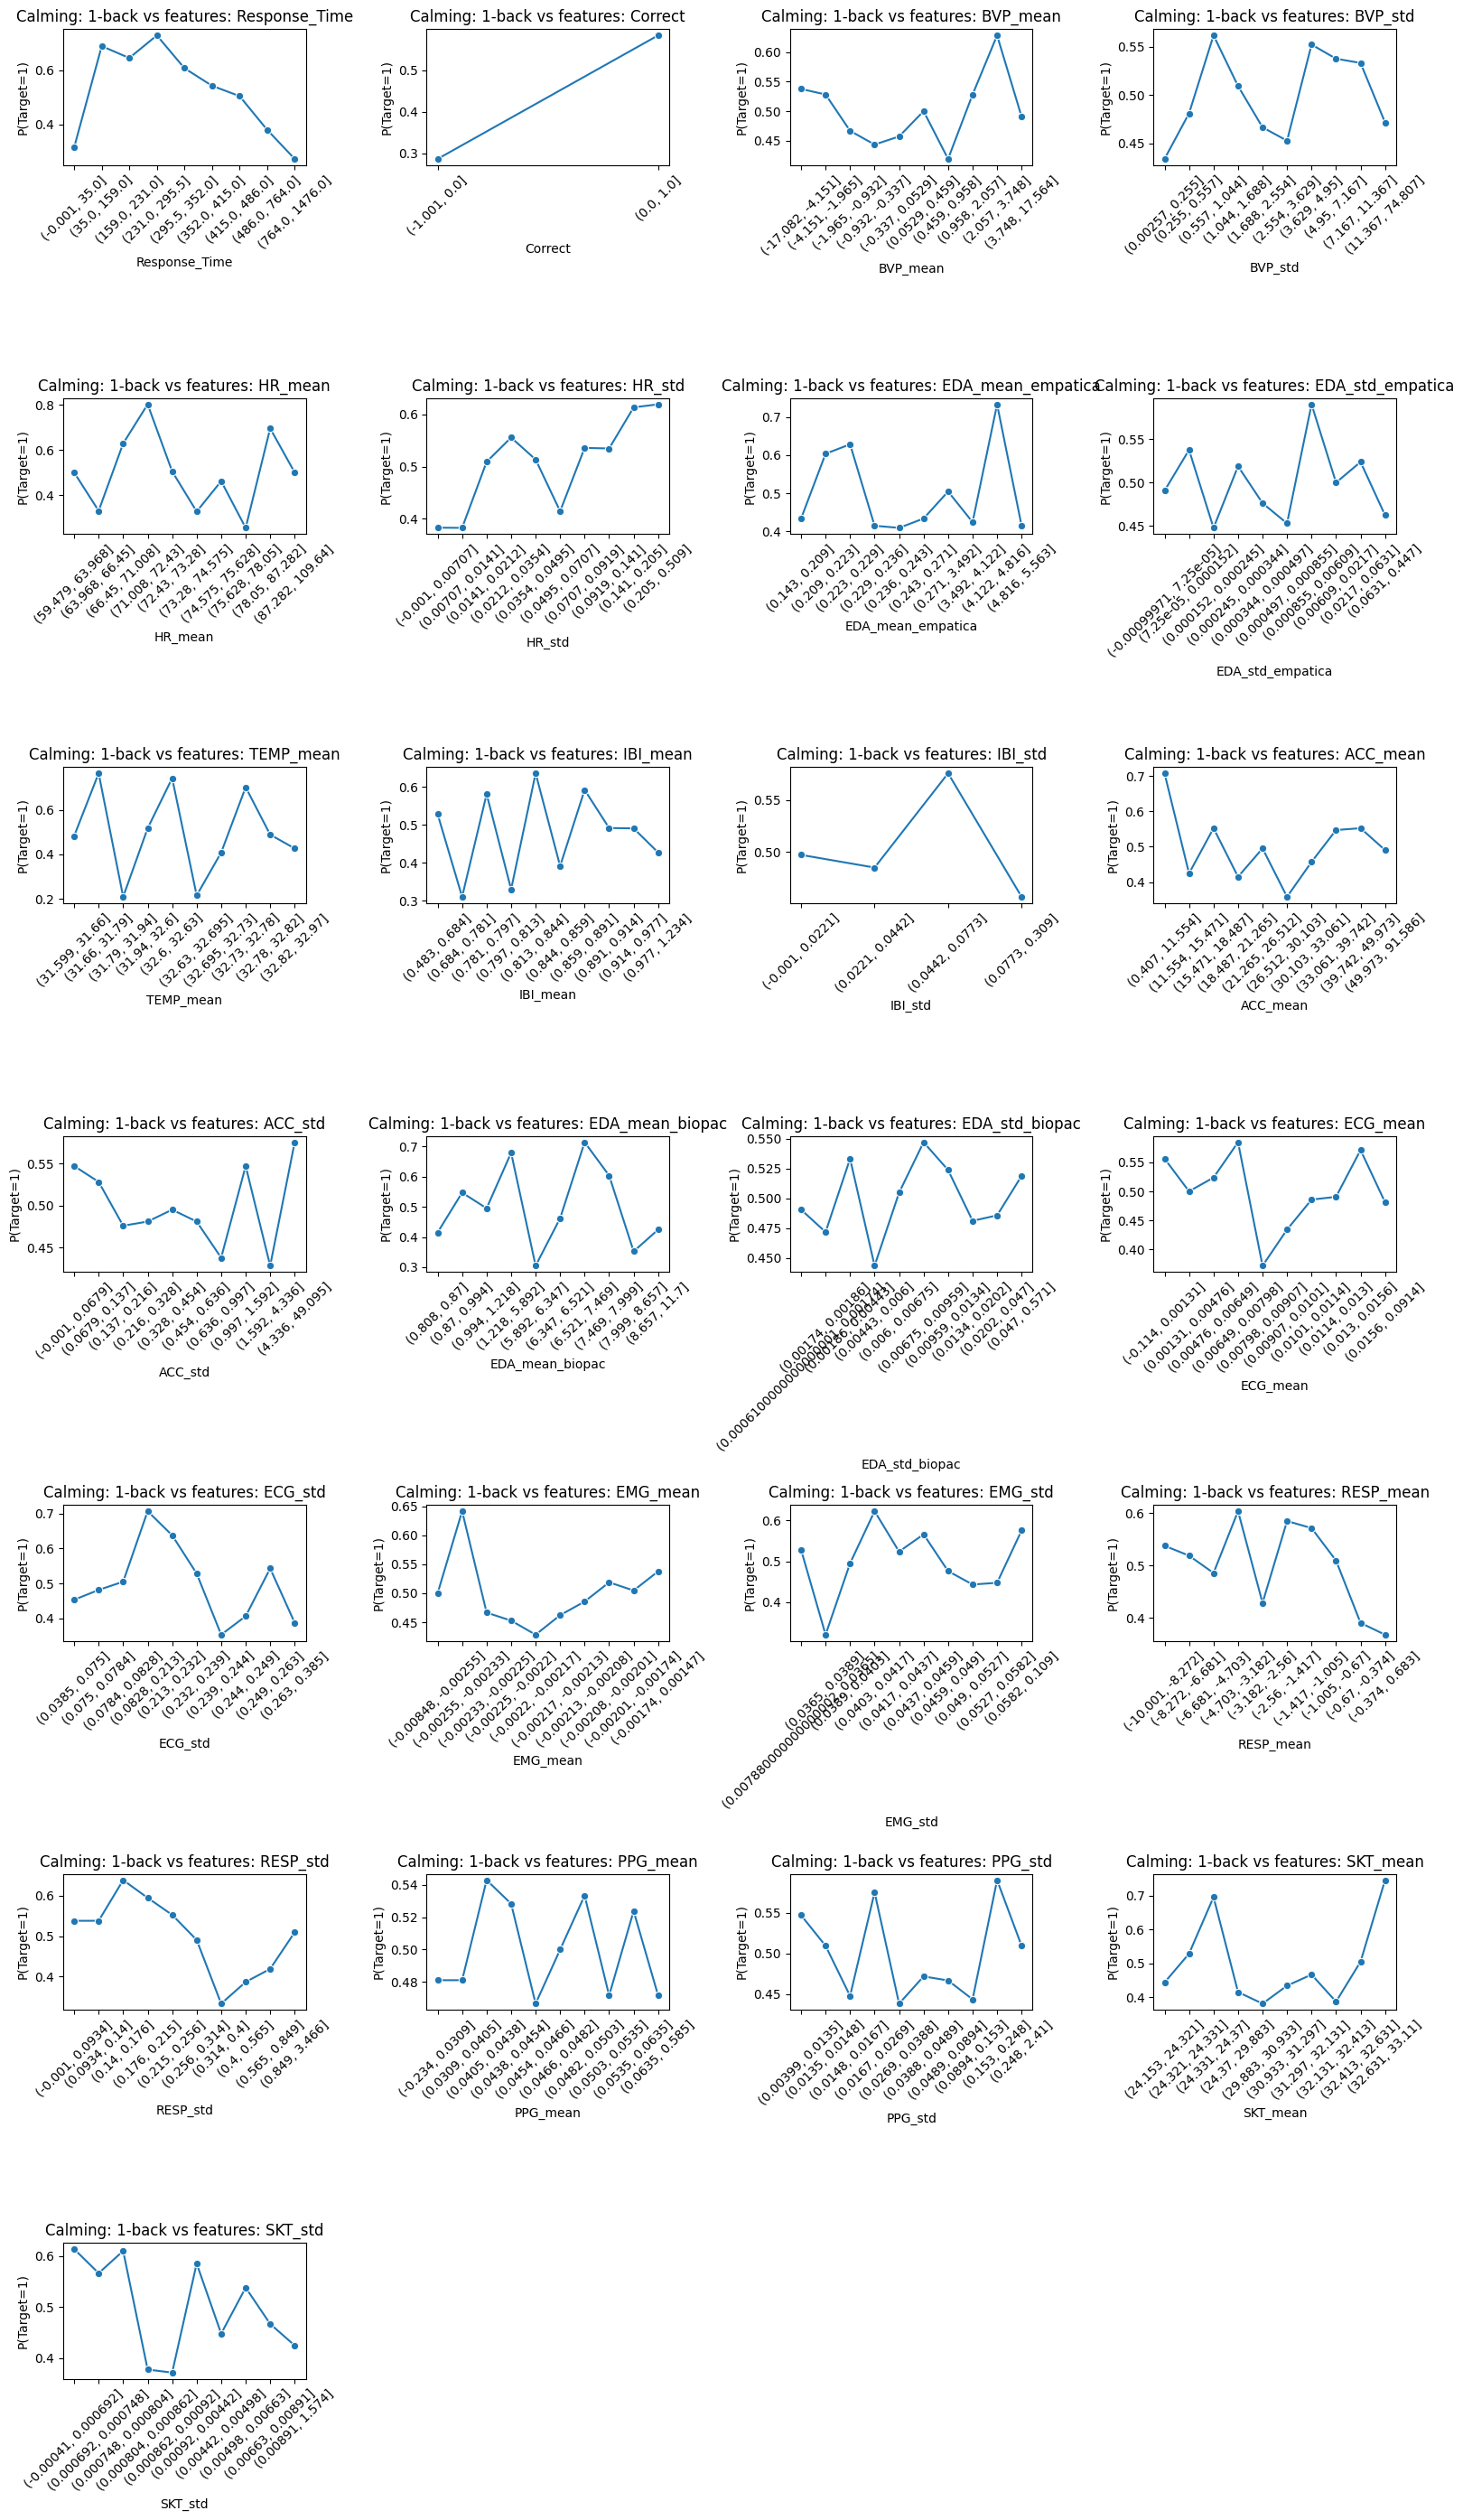

In [ ]:
# Plot features bins values against probability of 3_back value = 1
plot_all_features_probability_trend(calm_X_train, calm_y_train, title_prefix="Calming: 1-back vs features", save = True)

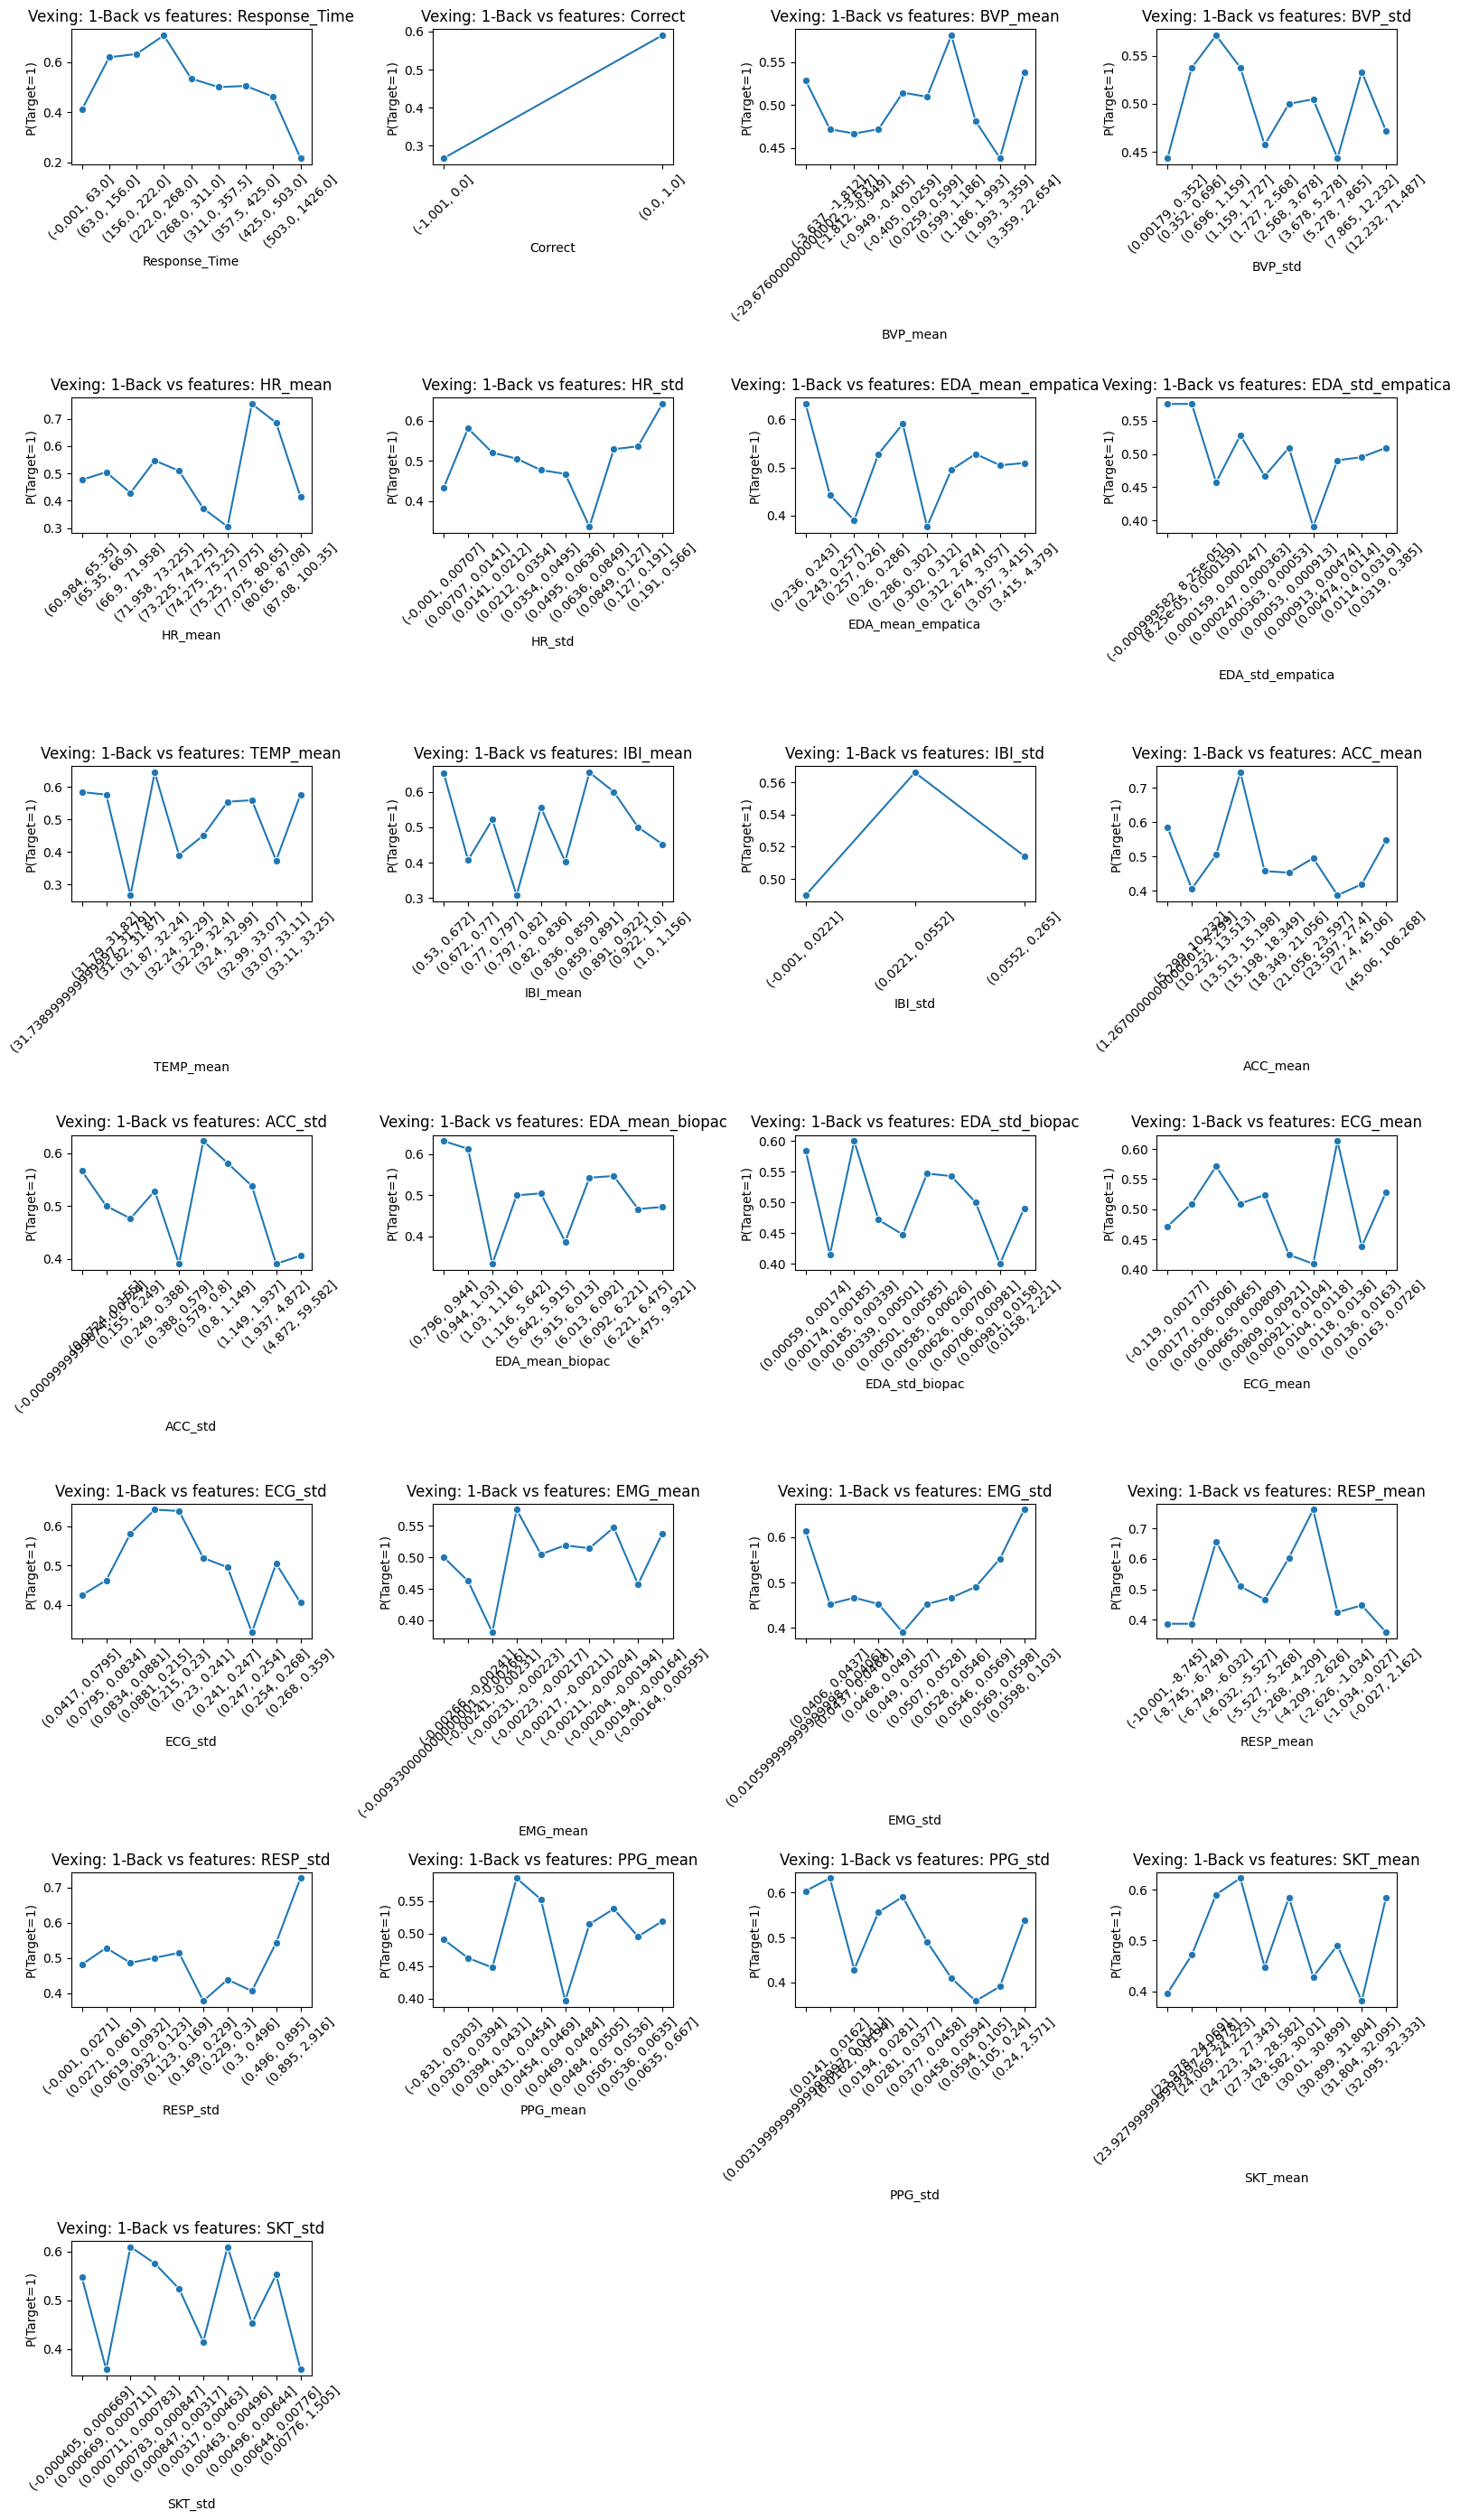

In [ ]:
# Plot features bins values against probability of 3_back value = 1
plot_all_features_probability_trend(vex_X_train, vex_y_train, title_prefix="Vexing: 1-Back vs features", save = True)

In [ ]:
calm_X_train_FE = feature_engineering(calm_X_train, calm_y_train, 0.05)
vex_X_train_FE = feature_engineering(vex_X_train, vex_y_train, 0.03)
condition_FE = feature_engineering(condition_X_train, condition_y_train, 0.05)


Feature correlations:
Correct              0.246588
HR_std               0.124619
Response_Time        0.107886
RESP_mean            0.059623
RESP_std             0.047054
SKT_std              0.039030
ECG_std              0.038174
EDA_std_empatica     0.032715
ACC_std              0.032237
EDA_std_biopac       0.029649
PPG_mean             0.028711
ECG_mean             0.026279
EMG_std              0.023868
BVP_std              0.022212
IBI_std              0.018356
TEMP_mean            0.018070
PPG_std              0.017382
SKT_mean             0.015683
IBI_mean             0.015456
EDA_mean_biopac      0.014946
HR_mean              0.011025
EMG_mean             0.009455
EDA_mean_empatica    0.006749
BVP_mean             0.004331
ACC_mean             0.003182
dtype: float64

Selecting features that have correlation > 0.05 with n-back label
Response_Time   -0.107886
Correct          0.246588
HR_std           0.124619
RESP_mean       -0.059623
dtype: float64


Feature correlations:
Co

In [ ]:
calm_X_retrain = calm_X_train[calm_X_train_FE]
vex_X_retrain = vex_X_train[vex_X_train_FE]

calm_X_revalid = calm_X_valid[calm_X_train_FE]
vex_X_revalid = vex_X_valid[vex_X_train_FE]

calm_X_retest = calm_X_test[calm_X_train_FE]
vex_X_retest = vex_X_test[vex_X_train_FE]

In [ ]:
condition_X_train_FE = condition_X_train[condition_FE]
condition_X_valid_FE = condition_X_valid[condition_FE]
condition_X_test_FE = condition_X_test[condition_FE]

### Music Condition Prediction

In [ ]:
condition_X_train, condition_X_valid, condition_X_test, condition_y_train, condition_y_valid, condition_y_test = split_data(music_df, model_predicting='condition')


--- Split Verification (80/10/10) ---
Total rows in X_train: 2112 (~80%)
Total rows in X_valid: 704 (~10%)
Total rows in X_test:  704 (~10%)

Training subjects:   ['Subject6' 'Subject11' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()


In [ ]:
condition_X_train.head()

,Response_Time,Correct,BVP_mean,BVP_std,HR_mean,HR_std,EDA_mean_empatica,EDA_std_empatica,TEMP_mean,IBI_mean,...,ECG_mean,ECG_std,EMG_mean,EMG_std,RESP_mean,RESP_std,PPG_mean,PPG_std,SKT_mean,SKT_std
704,0.0,0,-6.866983,4.143577,96.725,0.431335,0.143731,0.001510,31.62,0.484397,...,0.009592,0.239157,-0.002297,0.038816,-3.499566,0.205391,0.047063,0.014187,24.327730,0.004617
705,433.0,1,3.477187,28.346596,95.505,0.318198,0.143893,0.001298,31.61,0.484397,...,0.013199,0.246549,-0.002148,0.039642,-3.559666,0.161183,0.044943,0.013120,24.321215,0.000695
706,395.0,1,-0.394832,5.612661,94.870,0.212132,0.146725,0.000283,31.61,0.484397,...,0.008850,0.249883,-0.002393,0.040568,-3.513272,0.143495,0.046373,0.014130,24.314822,0.004861
707,36.0,1,1.458330,5.280786,94.275,0.205061,0.148449,0.000140,31.60,0.484397,...,0.012318,0.245407,-0.002095,0.039658,-3.411230,0.211652,0.044943,0.012395,24.311302,0.000738
708,453.0,1,0.124669,3.443051,93.725,0.205061,0.149334,0.001259,31.62,0.484397,...,0.002701,0.204481,-0.002177,0.033003,-3.488964,0.130214,0.046983,0.016080,24.311252,0.000733


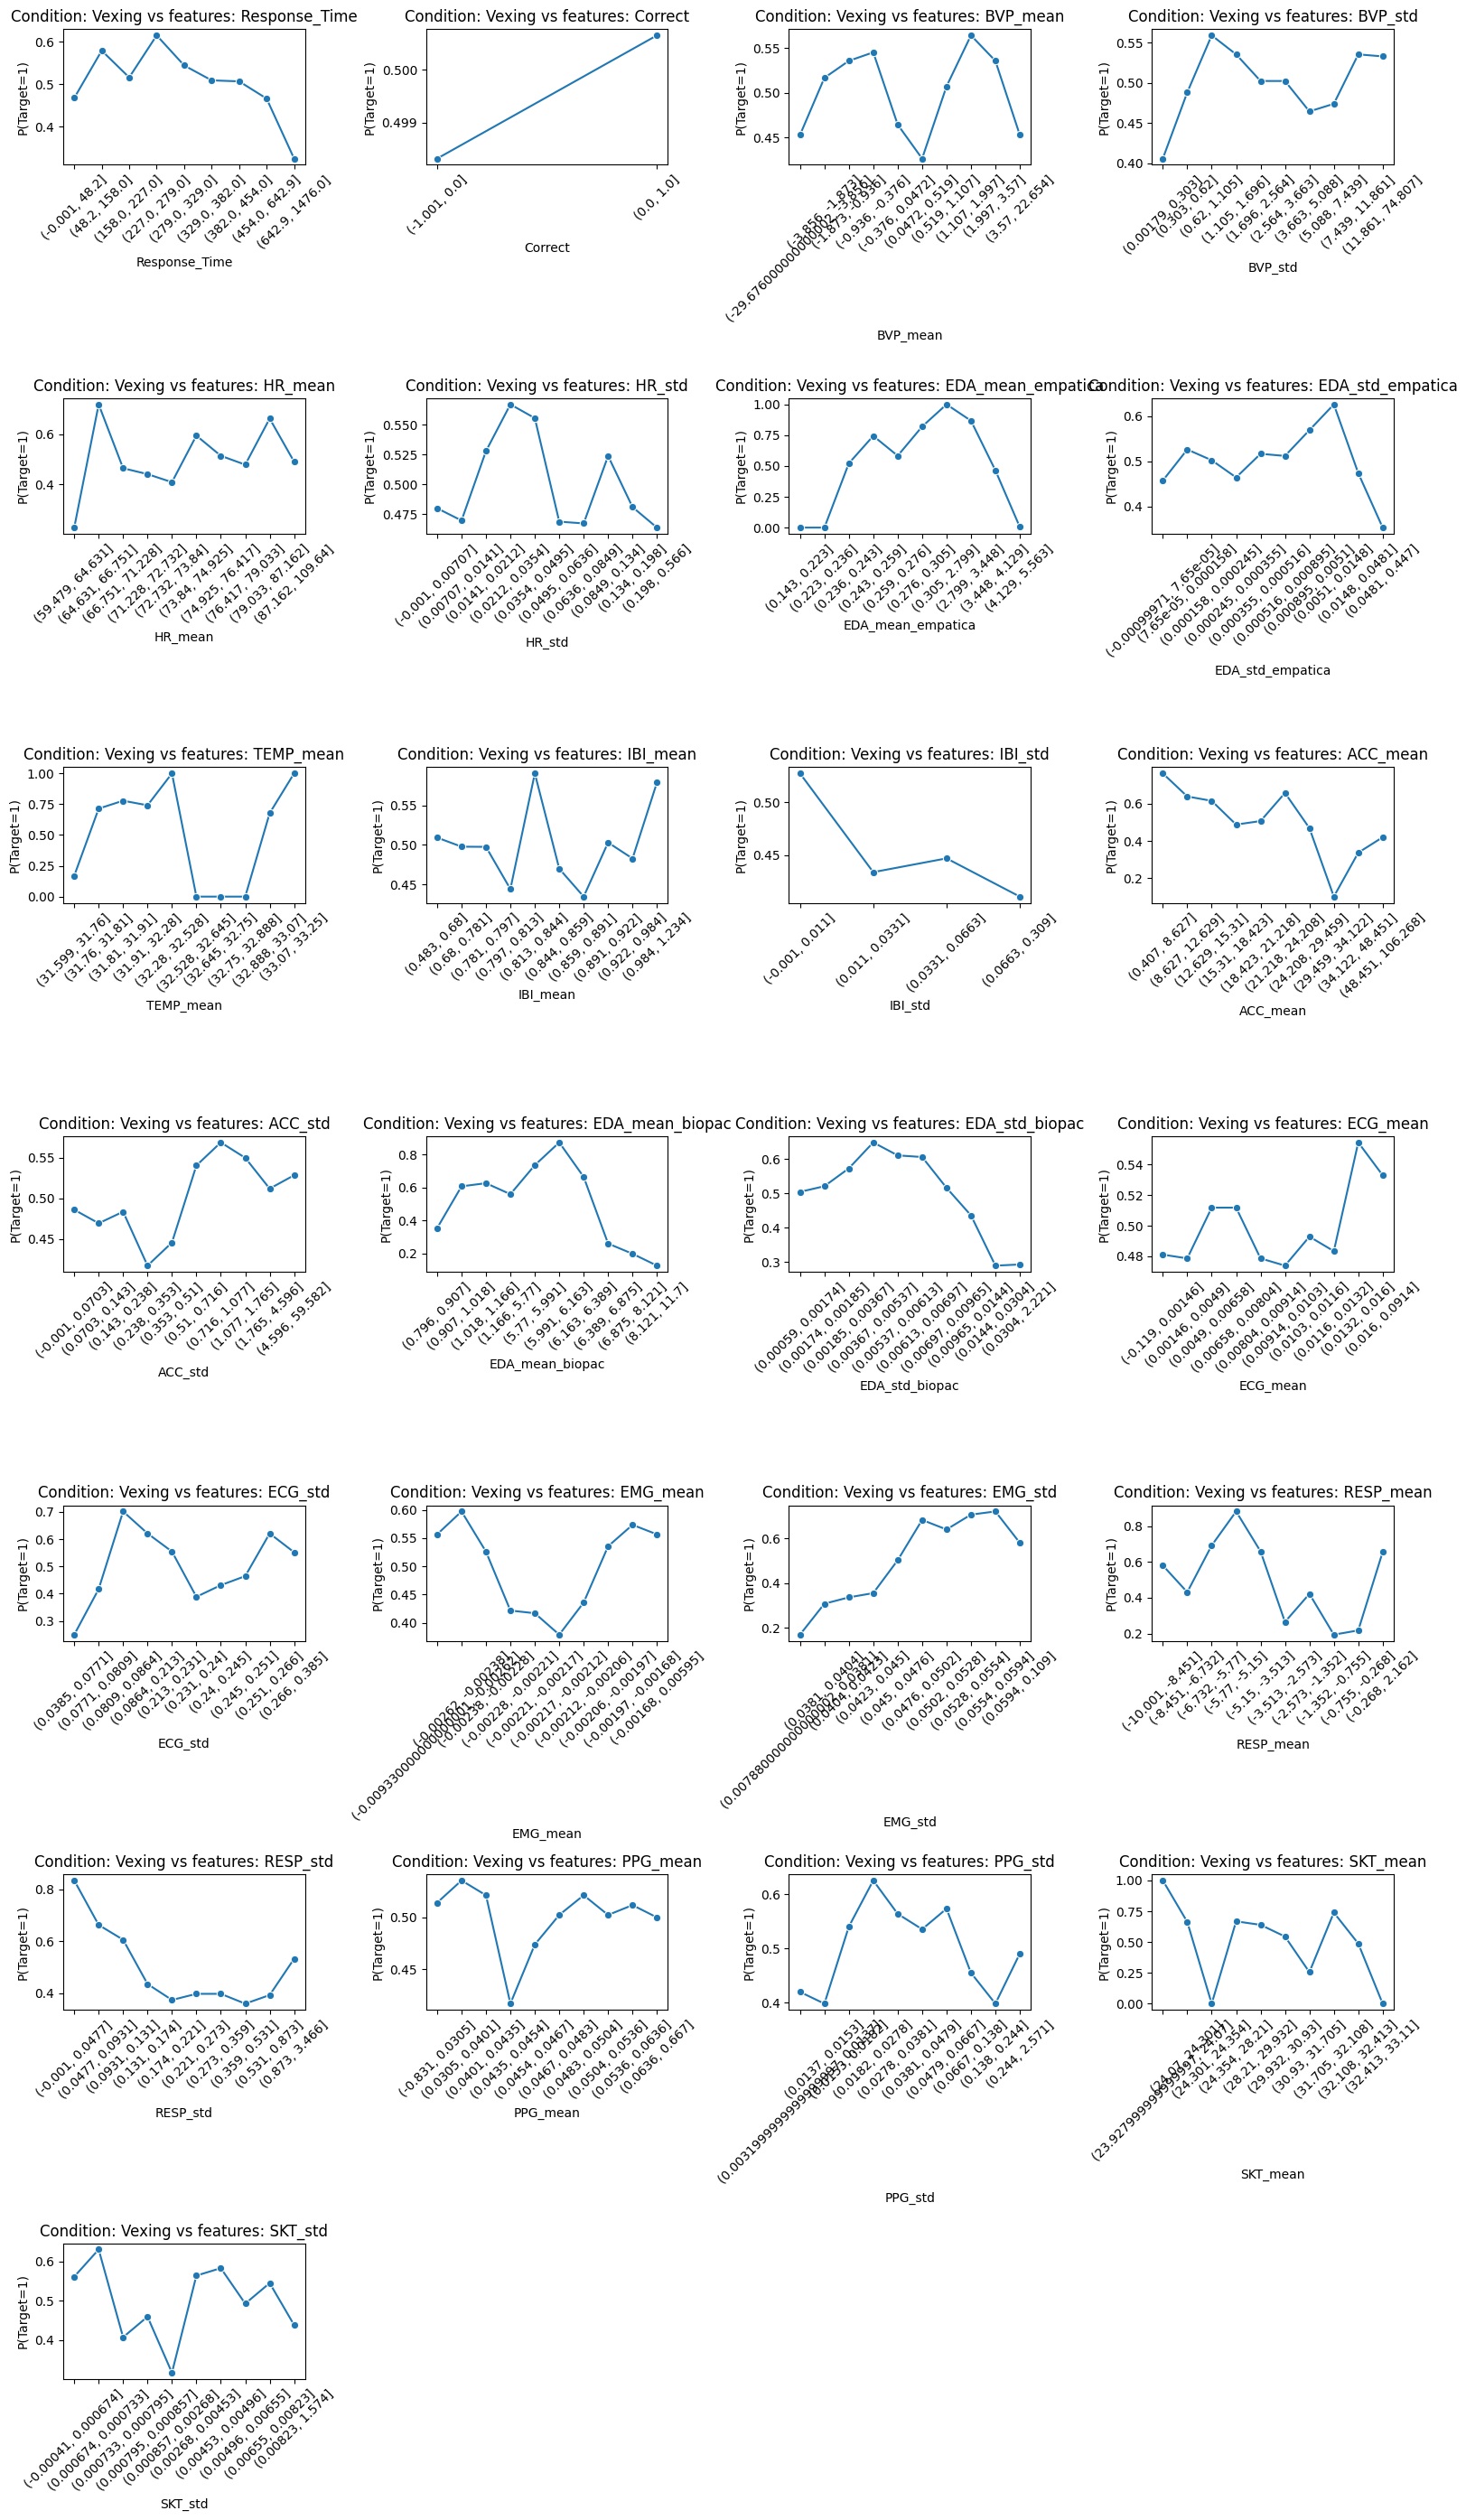

In [ ]:
# Plot of all features bins values against their probability of condition = True
plot_all_features_probability_trend(condition_X_train, condition_y_train, title_prefix="Condition: Vexing vs features")

In [ ]:
condition_FE = feature_engineering(condition_X_train, condition_y_train, 0.05)


Feature correlations:
EMG_std              0.264050
ACC_mean             0.214605
RESP_mean            0.179511
SKT_mean             0.149297
EDA_mean_biopac      0.127050
EDA_mean_empatica    0.102751
EDA_std_empatica     0.097433
Response_Time        0.094664
EDA_std_biopac       0.091782
IBI_std              0.082228
RESP_std             0.075936
ACC_std              0.046023
IBI_mean             0.040558
HR_mean              0.038973
PPG_std              0.038420
BVP_std              0.018291
ECG_std              0.017857
ECG_mean             0.016256
Correct              0.016251
HR_std               0.010015
SKT_std              0.007220
PPG_mean             0.005666
BVP_mean             0.002152
EMG_mean             0.001151
TEMP_mean            0.000996
dtype: float64

Selecting features that have correlation > 0.05 with n-back label
Response_Time       -0.094664
EDA_mean_empatica   -0.102751
EDA_std_empatica    -0.097433
IBI_std             -0.082228
ACC_mean            -0.21

In [ ]:
condition_X_train_FE = condition_X_train[condition_FE]
condition_X_valid_FE = condition_X_valid[condition_FE]
condition_X_test_FE = condition_X_test[condition_FE]

# 4. XGBoost classifier predicting n-back task

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def XGBC_train_and_evaluate_model(X_train, X_valid, X_test, y_train, y_valid, y_test, optimizing_model = False):

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)

  X_valid_scaled = scaler.transform(X_valid)
  X_test_scaled = scaler.transform(X_test)

  print("Feature scaling complete.")

  ############## OPTIMIZATION CODE - Below #####################
  if optimizing_model == True:
    print("Beginning XGBoost Hyperparameter Optimization")

  # combine train + valid for GridSearchCV
    X_tv = np.vstack([X_train_scaled, X_valid_scaled])
    y_tv = np.concatenate([y_train, y_valid])

    # tell CV: -1 means "always train", 0 means "validation fold"
    test_fold = np.r_[ -np.ones(len(y_train), dtype=int),
                      np.zeros(len(y_valid), dtype=int) ]
    ps = PredefinedSplit(test_fold)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1, 3],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [1, 5]
    }

    xgb_base = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        tree_method="hist"    )

    grid = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        scoring='f1',
        cv=ps,
        verbose=1,
        n_jobs=-1
    )

    grid.fit(
        X_tv, y_tv,
        eval_set=[(X_valid_scaled, y_valid)],
        verbose=False
    )

    print("Best Params:", grid.best_params_)
    print("Best Score:", grid.best_score_)

    # Replace model with optimized version
    model = grid.best_estimator_

  ############## OPTIMIZING CODE - Complete ######################
  else:
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                              early_stopping_rounds = 20,
                              random_state=42,reg_alpha=1,reg_lambda=2)

  print("Training the XGBoost model...")
  # Removed 'early_stopping_rounds' to resolve TypeError.
  # Model will now train for full number of boosting rounds.
  model.fit(X_train_scaled, y_train,
            eval_set=[(X_valid_scaled, y_valid)],
            # early_stopping_rounds = 10,
            verbose=False
           )
  print("Training complete.")

  # TRAINING EVALUATION
  y_pred_train = model.predict(X_train_scaled)
  train_acc = accuracy_score(y_train, y_pred_train)
  print("Training Accuracy:", train_acc * 100)

  # VALIDATION EVALUATION
  y_pred_valid = model.predict(X_valid_scaled)
  accuracy = accuracy_score(y_valid, y_pred_valid)

  print("\nModel Evaluation")
  print(f"Validation Accuracy: {accuracy * 100:.2f}%")
  print("Recall:", recall_score(y_valid, y_pred_valid)*100)
  print("F1 Score:", f1_score(y_valid, y_pred_valid)*100)
  print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_valid))

  # TEST EVALUATION
  y_pred_test = model.predict(X_test_scaled)
  test_acc = accuracy_score(y_test, y_pred_test)

  print("\nTest Evaluation")
  print(f"Test Accuracy: {test_acc * 100:.2f}%")
  print("Recall:", recall_score(y_test, y_pred_test)*100)
  print("F1 Score:", f1_score(y_test, y_pred_test)*100)
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

  print("\nFeature Importance")
  feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
  print(feature_importances)
  return model

## XGBoost without optimization

In [ ]:
# XGBoost on calm set
XGBC_train_and_evaluate_model(calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= False)

Feature scaling complete.
Training the XGBoost model...
Training complete.
Training Accuracy: 89.86742424242425

Model Evaluation
Validation Accuracy: 59.09%
Recall: 61.93181818181818
F1 Score: 60.22099447513812
Confusion Matrix:
 [[ 99  77]
 [ 67 109]]

Test Evaluation
Test Accuracy: 71.88%
Recall: 60.79545454545454
F1 Score: 68.370607028754
Confusion Matrix:
 [[146  30]
 [ 69 107]]

Feature Importance
Correct              0.235530
Response_Time        0.078302
EDA_mean_biopac      0.053930
TEMP_mean            0.052193
EDA_mean_empatica    0.049316
HR_std               0.049257
ACC_mean             0.041944
RESP_mean            0.039475
SKT_mean             0.038762
HR_mean              0.037060
RESP_std             0.034999
SKT_std              0.033193
EDA_std_biopac       0.027366
ECG_std              0.023559
EDA_std_empatica     0.023018
EMG_std              0.022692
ACC_std              0.022112
EMG_mean             0.021658
PPG_std              0.021010
IBI_mean             0.

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:42:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# XGBoost on vex set
XGBC_train_and_evaluate_model(vex_X_train, vex_X_valid, vex_X_test, vex_y_train, vex_y_valid, vex_y_test, optimizing_model= False)

Feature scaling complete.
Training the XGBoost model...


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:42:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Training complete.
Training Accuracy: 82.38636363636364

Model Evaluation
Validation Accuracy: 63.92%
Recall: 69.31818181818183
F1 Score: 65.76819407008087
Confusion Matrix:
 [[103  73]
 [ 54 122]]

Test Evaluation
Test Accuracy: 62.50%
Recall: 77.27272727272727
F1 Score: 67.32673267326733
Confusion Matrix:
 [[ 84  92]
 [ 40 136]]

Feature Importance
Correct              0.225872
Response_Time        0.096016
PPG_std              0.055292
RESP_mean            0.048588
HR_mean              0.048495
EDA_mean_biopac      0.045197
SKT_mean             0.044656
TEMP_mean            0.044083
ECG_std              0.043793
IBI_mean             0.038013
EDA_mean_empatica    0.034134
RESP_std             0.028877
ACC_mean             0.027538
BVP_std              0.026821
EMG_std              0.025806
IBI_std              0.021909
SKT_std              0.020218
ACC_std              0.019126
HR_std               0.018616
EDA_std_biopac       0.018604
EDA_std_empatica     0.016860
ECG_mean         

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## XGBoost with optimization and no feature selection

In [ ]:
# XGBoost on calm set
XGBC_train_and_evaluate_model(calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= True)

Feature scaling complete.
Beginning XGBoost Hyperparameter Optimization
Fitting 1 folds for each of 576 candidates, totalling 576 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 1.0}
Best Score: 0.6976744186046512
Training the XGBoost model...
Training complete.
Training Accuracy: 91.85606060606061

Model Evaluation
Validation Accuracy: 63.07%
Recall: 85.22727272727273
F1 Score: 69.76744186046511
Confusion Matrix:
 [[ 72 104]
 [ 26 150]]

Test Evaluation
Test Accuracy: 62.78%
Recall: 52.27272727272727
F1 Score: 58.41269841269842
Confusion Matrix:
 [[129  47]
 [ 84  92]]

Feature Importance
Correct              0.123803
Response_Time        0.091556
EDA_mean_biopac      0.070048
HR_std               0.066506
EDA_mean_empatica    0.060493
ECG_std              0.050754
HR_mean              0.050123
TEMP_mean            0.049558
RESP_std             0.048037
RESP_mean          

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# XGBoost on vex set
XGBC_train_and_evaluate_model(vex_X_train, vex_X_valid, vex_X_test, vex_y_train, vex_y_valid, vex_y_test, optimizing_model= True)

Feature scaling complete.
Beginning XGBoost Hyperparameter Optimization
Fitting 1 folds for each of 576 candidates, totalling 576 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best Score: 0.7006960556844548
Training the XGBoost model...
Training complete.
Training Accuracy: 94.88636363636364

Model Evaluation
Validation Accuracy: 63.35%
Recall: 85.79545454545455
F1 Score: 70.06960556844548
Confusion Matrix:
 [[ 72 104]
 [ 25 151]]

Test Evaluation
Test Accuracy: 59.94%
Recall: 60.79545454545454
F1 Score: 60.281690140845065
Confusion Matrix:
 [[104  72]
 [ 69 107]]

Feature Importance
Correct              0.169995
TEMP_mean            0.061004
Response_Time        0.060974
HR_mean              0.054365
RESP_mean            0.053097
EDA_mean_biopac      0.051608
PPG_std              0.050620
SKT_mean             0.050163
IBI_mean             0.041687
ECG_std           

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

## XGBoost with optimization and feature selection

In [ ]:
# Optimized XGBoost on calm set
XGBC_train_and_evaluate_model(calm_X_retrain, calm_X_revalid, calm_X_retest, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= True)

Feature scaling complete.
Beginning XGBoost Hyperparameter Optimization
Fitting 1 folds for each of 576 candidates, totalling 576 fits
Best Params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
Best Score: 0.725925925925926
Training the XGBoost model...
Training complete.
Training Accuracy: 73.39015151515152

Model Evaluation
Validation Accuracy: 68.47%
Recall: 83.52272727272727
F1 Score: 72.5925925925926
Confusion Matrix:
 [[ 94  82]
 [ 29 147]]

Test Evaluation
Test Accuracy: 61.36%
Recall: 36.93181818181818
F1 Score: 48.87218045112782
Confusion Matrix:
 [[151  25]
 [111  65]]

Feature Importance
Correct          0.501430
Response_Time    0.230943
RESP_mean        0.134383
HR_std           0.133245
dtype: float32


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Optimized XGBoost on vex set
XGBC_train_and_evaluate_model(vex_X_retrain, vex_X_revalid, vex_X_retest, vex_y_train, vex_y_valid, vex_y_test, optimizing_model= True)

Feature scaling complete.
Beginning XGBoost Hyperparameter Optimization
Fitting 1 folds for each of 576 candidates, totalling 576 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 1.0}
Best Score: 0.7027027027027027
Training the XGBoost model...
Training complete.
Training Accuracy: 76.04166666666666

Model Evaluation
Validation Accuracy: 65.62%
Recall: 81.25
F1 Score: 70.27027027027027
Confusion Matrix:
 [[ 88  88]
 [ 33 143]]

Test Evaluation
Test Accuracy: 65.34%
Recall: 77.8409090909091
F1 Score: 69.1919191919192
Confusion Matrix:
 [[ 93  83]
 [ 39 137]]

Feature Importance
Correct           0.387393
Response_Time     0.138547
EMG_std           0.088270
RESP_std          0.081496
ACC_std           0.080280
SKT_std           0.077823
HR_std            0.076386
EDA_std_biopac    0.069805
dtype: float32


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

# 5. XGBoost classifier predicting music condition

## XGBoost without optimization

In [ ]:
XGBC_train_and_evaluate_model(condition_X_train, condition_X_valid, condition_X_test, condition_y_train, condition_y_valid, condition_y_test, optimizing_model=False)

Feature scaling complete.
Training the XGBoost model...
Training complete.
Training Accuracy: 98.20075757575758

Model Evaluation
Validation Accuracy: 50.00%
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[352   0]
 [352   0]]

Test Evaluation
Test Accuracy: 50.00%
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[352   0]
 [352   0]]

Feature Importance
EDA_mean_empatica    0.339378
EDA_mean_biopac      0.303133
SKT_mean             0.160426
TEMP_mean            0.108112
EMG_std              0.051062
ACC_mean             0.016429
HR_mean              0.011321
RESP_mean            0.005760
ECG_std              0.002035
ACC_std              0.000968
SKT_std              0.000858
RESP_std             0.000518
HR_std               0.000000
Correct              0.000000
Response_Time        0.000000
BVP_mean             0.000000
BVP_std              0.000000
EDA_std_empatica     0.000000
EDA_std_biopac       0.000000
IBI_std              0.000000
IBI_mean             0.000000
ECG_mean         

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## XGBoost with feature selection and no optimization

In [ ]:
XGBC_train_and_evaluate_model(condition_X_train_FE, condition_X_valid_FE, condition_X_test_FE, condition_y_train, condition_y_valid, condition_y_test, optimizing_model=False)

Feature scaling complete.
Training the XGBoost model...
Training complete.
Training Accuracy: 99.3844696969697

Model Evaluation
Validation Accuracy: 50.00%
Recall: 100.0
F1 Score: 66.66666666666666
Confusion Matrix:
 [[  0 352]
 [  0 352]]

Test Evaluation
Test Accuracy: 34.66%
Recall: 69.31818181818183
F1 Score: 51.47679324894515
Confusion Matrix:
 [[  0 352]
 [108 244]]

Feature Importance
EDA_mean_empatica    0.357357
EDA_mean_biopac      0.206817
EMG_std              0.193378
SKT_mean             0.130791
RESP_mean            0.035609
ACC_mean             0.027370
RESP_std             0.026965
EDA_std_biopac       0.015723
EDA_std_empatica     0.003767
Response_Time        0.002223
IBI_std              0.000000
dtype: float32


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## XGBoost with optimization and feature selection

In [ ]:
XGBC_train_and_evaluate_model(condition_X_train_FE, condition_X_valid_FE, condition_X_test_FE, condition_y_train, condition_y_valid, condition_y_test, optimizing_model=True)

Feature scaling complete.
Beginning XGBoost Hyperparameter Optimization
Fitting 1 folds for each of 576 candidates, totalling 576 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best Score: 0.6666666666666666
Training the XGBoost model...
Training complete.
Training Accuracy: 96.49621212121212

Model Evaluation
Validation Accuracy: 50.00%
Recall: 100.0
F1 Score: 66.66666666666666
Confusion Matrix:
 [[  0 352]
 [  0 352]]

Test Evaluation
Test Accuracy: 46.88%
Recall: 93.75
F1 Score: 63.829787234042556
Confusion Matrix:
 [[  0 352]
 [ 22 330]]

Feature Importance
EDA_mean_empatica    0.224603
EMG_std              0.205777
SKT_mean             0.167079
EDA_mean_biopac      0.138557
RESP_mean            0.119231
RESP_std             0.061589
EDA_std_empatica     0.043299
ACC_mean             0.039453
EDA_std_biopac       0.000411
Response_Time        0.000000
IBI_std     

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)